In [12]:
#import torch
#import torch.nn as nn
#from torch.autograd import Variable
#import torch.utils.data as data
#import os
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#from tqdm.auto import tqdm
#import random
#from torch import optim
import math
#import pypianoroll
#import Functions as F

# Customized Dataset

In [2]:
import os
import pandas as pd
import numpy as np
class customDataset(data.Dataset):
    def __init__(self,path):
        self.path = path
        fnames = os.listdir(path)
        fnames_ful = map(lambda fname: os.path.join(path, fname), fnames)
        # hold a list of full file paths
        self.fnames_ful = list(fnames_ful)
        print("Total samples: ", len(self.fnames_ful))
    
    def __len__(self):
        return len(self.fnames_ful)
    
    def __getitem__(self, index):
        fnames_ful = self.fnames_ful[index]
        roll = pd.read_csv(fnames_ful,header=None)
        roll = np.array(roll)
        # input sequence is from first element til the second last so that
        #  the model could predict from the second element til the last one
        input_seq = roll[:-1,:]
        # we expect the model to predict the final 10 elements
        output_seq = roll[1:,:]
        #output_seq = roll[1:,:]
        return (input_seq,output_seq)
        
        

# Dataloaders

In [3]:
path = "Pop-music - One Hot/Train"

train_dataset = customDataset(path)
train_dataloader = data.DataLoader(train_dataset,batch_size=32,shuffle=True)

Total samples:  28375


In [4]:
# check
X_train=next(iter(train_dataloader))
print(X_train[0].shape) # input seq
print(X_train[1].shape) # output seq

torch.Size([32, 1999, 88])
torch.Size([32, 1999, 88])


In [5]:
# validation set

path = "Pop-music - One Hot/Val"
#val_dataset = customDataset(path)
val_dataset = customDataset(path)
# seperate val set into 5 sets because validate 40,000 every time is too much
#  now it would only validate on 8,000
set1 = list(range(0,len(val_dataset),3))
set2 = list(range(1,len(val_dataset),3))
set3 = list(range(2,len(val_dataset),3))
#set4 = list(range(3,len(val_dataset),5))
#set5 = list(range(4,len(val_dataset),5))

val1 = data.Subset(val_dataset,set1)
val2 = data.Subset(val_dataset,set2)
val3 = data.Subset(val_dataset,set3)
#val4 = data.Subset(val_dataset,set4)
#val5 = data.Subset(val_dataset,set5)""

size = 64
val_dataloader1 = data.DataLoader(val1,batch_size=size,shuffle=True)
val_dataloader2 = data.DataLoader(val2,batch_size=size,shuffle=True)
val_dataloader3 = data.DataLoader(val3,batch_size=size,shuffle=True)
#val_dataloader4 = data.DataLoader(val4,batch_size=size,shuffle=True)
#val_dataloader5 = data.DataLoader(val5,batch_size=size,shuffle=True)

val_dataloaders = [val_dataloader1,
               val_dataloader2,
                val_dataloader3]

Total samples:  4350


In [6]:
# check
X_val = next(iter(val_dataloader1))
print(X_val[0].shape) # input seq
print(X_val[1].shape) # output seq

torch.Size([64, 1999, 88])
torch.Size([64, 1999, 88])


## visualization

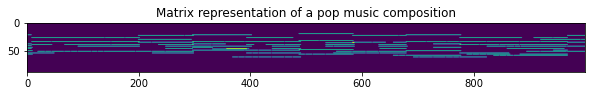

In [8]:
plt.figure(figsize=(10,7))
plt.title("Matrix representation of a pop music composition")
plt.imshow(X_train[0][4][:1000].T)

# Training and validation Routine

In [9]:
def evaluate(model,val_loader,device,loss_fn):
    model.eval()
    val_loss = 0.0
    steps = 0
    
    for batch in val_loader:
        steps += 1
        input_seq, output_seq = batch
        input_seq, output_seq = input_seq.to(device), output_seq.to(device)
        # try to fix error :"addmm_cuda" not implemented for 'Long'
        input_seq = input_seq.float()
        
        output_seq = output_seq.transpose(0,1).contiguous()
        output_seq = output_seq.contiguous().view(-1)
        
        final,_ = model(input_seq)
        # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
        #final, output_seq = final.double(),output_seq.double()
        loss = loss_fn(final,output_seq)
        val_loss += loss.item()
    
    print("The mean validation loss is %.6f" % (val_loss/steps))
    print()
    return val_loss/steps

In [10]:
def train(model,trainloader,valloaders,ep,print_freq,loss_fun,
          optimizer,device,run,grad_clip=1.0,mname="LSTM"):
    val_loss_best = float("inf")
    
    # total number of training steps
    num_steps = ep * (len(trainloader))
    progress_bar = tqdm(range(num_steps))
    
    # calculate how often print the result
    #  if num_step = 12, and print_freq = 3, then print every 4 steps
    print_every = math.floor(num_steps/print_freq)
    
    # initialize
    steps = 0
    #model.to(device) ## error when run this twice
    model.train()
    train_losses = []
    val_losses = []
    which_val = 0
    
    for e in range(ep):
        current_loss = 0
        for batch in trainloader:
            input_s, output_s = batch
            steps += 1
            input_seq, output_seq = input_s.to(device), output_s.to(device)
            # try to fix error :"addmm_cuda" not implemented for 'Long'
            #  note: output_seq should stay long (int)
            input_seq = input_seq.float()
            #print("input shape: ",input_seq.shape)
            
            output_seq = output_seq.transpose(0,1).contiguous()
            #print("original output shape: ", output_seq.shape)
            output_seq = output_seq.contiguous().view(-1)

            
            # calculate grad and update
            optimizer.zero_grad()
            final,_ = model(input_seq)
            loss = loss_fun(final, output_seq)
            #print("loss: ", loss)
            train_losses.append(loss.item())
            current_loss += loss.item()
            #print(current_loss)
            # update parameter
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            optimizer.step()
            
            # update progress bar
            progress_bar.update(1)
            
            # print if reach the threshold we want
            if steps % print_every == 0:
                # training loss: divided by the number of steps taken during training
                #  from last print to current print
                print('EPOCHS : {}/{}'.format(e+1,ep),
                          'Loss : {:.6f}'.format(current_loss/print_every))

                current_loss = 0
                #which_val = random.randint(0,4)
                which_val = random.randint(0,2) # now I only have 2 val sets
                # val loss: divided by the number of steps taken when validate
                val_loss = evaluate(model,valloaders[which_val],device,loss_fun)
                val_losses.append(val_loss)
                
                # add call back
                if val_loss < val_loss_best:
                    val_loss_best = val_loss
                    torch.save(model.state_dict(),
                     "Handcrafted Dataset - One Hot Weights/"+mname+"-run-{}-val_loss-BEST.pth".format(run))
            model.train()
    return train_losses, val_losses

# Model

In [11]:
class PopBaseLSTM(nn.Module):
    def __init__(self, input_size = 88, embed_size = 256, hidden_size = 512, 
                  num_class = 88, layers = 1):
        super(PopBaseLSTM, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=embed_size)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)

        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        notes_encoded = self.notes_encoder(sequences) # shape (batch,seq_len,embed_size)
        #notes_rolled = notes_encoded.permute(1,2,0).contiguous()
                                                      # shape (seq_len,embed_size,batch)
        notes_rolled = notes_encoded
        notes_lnormed = self.layernorm_encoder(notes_rolled)
        notes_lnormed = nn.Dropout(0.1)(notes_lnormed)
        #notes = notes_lnormed.permute(2,0,1)          # shape (batch,seq_len,embed_size)
        notes = notes_lnormed
        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.1)(output_lnormed)
        

        
        # only take the final 1000
        #output_lnormed = output_lnormed[:,-1000:,:] 
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)
        
        ###
        #final = self.relu(final)
        #final = nn.Dropout(0.5)(final)
        #final = self.final2(final)
        
        
        ###
        
        # final shape (200,batch,88)
        final = final.transpose(0,1).contiguous()
        #print("original final shape: ", final.shape)
        
        # create a second measure for prediction per class, shape(seq_len,batch,num_class)
        neg_final = 1 - final
        
        # two "predictions" for each node
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        
        # flatten everything except for the two predictions dimension
        flatten_final = zero_one_final.view(-1,2)
        
        return flatten_final, hidden

# BaseLSTM1 - length 2000
batchsize = 32

In [12]:
PopBaseLSTM1 = PopBaseLSTM(input_size = 88, embed_size = 256, hidden_size = 512, 
                  num_class = 88, layers = 1).cuda()
optimizer = optim.AdamW(PopBaseLSTM1.parameters(),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [15]:
train_loss, val_loss = train(PopBaseLSTM1,train_dataloader,val_dataloaders,1,20,loss_fn,
          optimizer,"cuda",1,grad_clip=1.0,mname="PopBaseLSTM1")

  0%|          | 0/887 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.421925
The mean validation loss is 0.0654

EPOCHS : 1/1 Loss : 0.155907
The mean validation loss is 0.0340

EPOCHS : 1/1 Loss : 0.103671
The mean validation loss is 0.0172

EPOCHS : 1/1 Loss : 0.072764
The mean validation loss is 0.0098

EPOCHS : 1/1 Loss : 0.055441
The mean validation loss is 0.0061

EPOCHS : 1/1 Loss : 0.045409
The mean validation loss is 0.0041

EPOCHS : 1/1 Loss : 0.038642
The mean validation loss is 0.0030

EPOCHS : 1/1 Loss : 0.034670
The mean validation loss is 0.0023

EPOCHS : 1/1 Loss : 0.031799
The mean validation loss is 0.0018

EPOCHS : 1/1 Loss : 0.029651
The mean validation loss is 0.0015

EPOCHS : 1/1 Loss : 0.027696
The mean validation loss is 0.0013

EPOCHS : 1/1 Loss : 0.027029
The mean validation loss is 0.0011

EPOCHS : 1/1 Loss : 0.026093
The mean validation loss is 0.0011

EPOCHS : 1/1 Loss : 0.025644
The mean validation loss is 0.0010

EPOCHS : 1/1 Loss : 0.024760
The mean validation loss is 0.0009

EPOCHS : 1/1 Loss : 0.024

In [13]:
optimizer = optim.AdamW(PopBaseLSTM1.parameters(),lr=5e-6)
PopBaseLSTM1.load_state_dict(torch.load("Handcrafted Dataset - One Hot Weights/PopBaseLSTM1-run-1-val_loss-BEST.pth"))
train_loss, val_loss = train(PopBaseLSTM1,train_dataloader,val_dataloaders,1,10,loss_fn,
          optimizer,"cuda",2,grad_clip=1.0,mname="PopBaseLSTM1")

  0%|          | 0/887 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.023773
The mean validation loss is 0.000904

EPOCHS : 1/1 Loss : 0.023744
The mean validation loss is 0.000903

EPOCHS : 1/1 Loss : 0.023781
The mean validation loss is 0.000916

EPOCHS : 1/1 Loss : 0.023469
The mean validation loss is 0.000937

EPOCHS : 1/1 Loss : 0.023208
The mean validation loss is 0.000984

EPOCHS : 1/1 Loss : 0.023055
The mean validation loss is 0.001014

EPOCHS : 1/1 Loss : 0.022995
The mean validation loss is 0.001048

EPOCHS : 1/1 Loss : 0.022740
The mean validation loss is 0.001102

EPOCHS : 1/1 Loss : 0.022962
The mean validation loss is 0.001160

EPOCHS : 1/1 Loss : 0.022977
The mean validation loss is 0.001249



In [14]:
train_loss, val_loss = train(PopBaseLSTM1,train_dataloader,val_dataloaders,4,20,loss_fn,
          optimizer,"cuda",3,grad_clip=1.0,mname="PopBaseLSTM1")

  0%|          | 0/3548 [00:00<?, ?it/s]

EPOCHS : 1/4 Loss : 0.022732


RuntimeError: CUDA out of memory. Tried to allocate 1.01 GiB (GPU 0; 6.00 GiB total capacity; 2.02 GiB already allocated; 623.38 MiB free; 3.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Generate Music

In [23]:
# define a function to extract hidden state given the beginning of a piece of music
#  it should start from time step 0, extract the piano roll, take the first portion 
#   to generate hidden space and last prediction from the model
def get_hidden(model, path,len_input_seq=200,ln=200,tmp=1,start_position=0):
    # extract piano roll from the music and form one hot encoding
    multitrack = pypianoroll.read(path)
    multitrack.binarize()
    combined_track = multitrack.blend()
    # shrink the pitches and extract the part that we need
    track_len = len(combined_track[:,0]) 
    # if track_len is less than the track they want
    if (track_len < len_input_seq + start_position):
        if (track_len < len_input_seq):
            input_seq = combined_track[:,21:109] # take the entire trach
        else:
            input_seq = combined_track[start_position:,21:109] 
    else:
        end_position = start_position + len_input_seq - 1
        input_seq = combined_track[start_position:end_position,21:109]
    
    # input sequence must be a tensor
    input_seq = torch.tensor(input_seq,dtype=torch.float)
    
    # add batch dimension
    input_seq = torch.unsqueeze(input_seq,0)
    
    op, hidden = model(input_seq) # note hidden state don't stack
    
    # only take the last observations of each
    output = op[-88:]
    probs = nn.functional.softmax(output.div(tmp), dim=1)
    output = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
    output = output.float()
 
    # hidden size (2,2,200,512), should go with (2,2,1,512)
    h,c = hidden
    h = h[:,-1:,:]
    c = c[:,-1:,:]
    hidden = (h,c)
    
    return generate_music(model,output,hidden,ln,tmp)

# define a function to generate music based on the hidden state of the music
def generate_music(model, start, hidden, ln=200, tmp=1):
    seq_ip_cur = start
        
    op_seq = [seq_ip_cur.data.squeeze(1)]
    hd = hidden

    for i in range(ln):

        # input sequence is predicted outputs
        op, hd = model(seq_ip_cur, hd) # output is a vector of 88
        #print("output: ",op)
        
        probs = nn.functional.softmax(op.div(tmp), dim=1)
        #print("probabilities: ",probs)
        
        # update current sequence to the previous prediction
        seq_ip_cur = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        # the model accept input as tensor of floats
        seq_ip_cur = seq_ip_cur.float()
        #print("updated sequence: ", seq_ip_cur.data.squeeze(1))

        # append outputs
        op_seq.append(seq_ip_cur.data.squeeze(1))

    gen_seq = torch.cat(op_seq, dim=0).cpu().numpy()
    
    return gen_seq

def generate_sample(model,model_val,run,musicname="mz_330_1.mid",len_input_seq=200,
                    ln=200,tmp=1,model_name="LSTM_Chopin",start_position=0):
    weights_folder = "Handcrafted Dataset - One Hot Weights"
    
    # this is for simple version
    #LSTM = model(input_size=88,embed_size=512,hidden_size=512,num_class=88).cpu() 
    
    LSTM = model(88,256,512,88,1).cpu() 
    weights = model_name+"-run-"+str(run)+"-val_loss-"+model_val+ ".pth"
    weights_path = os.path.join(weights_folder,weights)
    LSTM.load_state_dict(torch.load(weights_path))
    

    musicpath = "Handcrafted Dataset - Generated Music/input/Pop/" + musicname
    LSTM.eval()
    seq = get_hidden(LSTM,musicpath,len_input_seq,ln,tmp,start_position)
    
    plt.figure(figsize=(10,7))
    plt.imshow(seq.T)
    
    outputpath = 'Handcrafted Dataset - Generated Music/'+model_name+'/run'+str(run)+'-'+model_val+'-'+musicname
    return seq, outputpath

### PopBaseLSTM1

Handcrafted Dataset - Generated Music/PopBaseLSTM1/run1-BEST-Someone_you_loved.midi


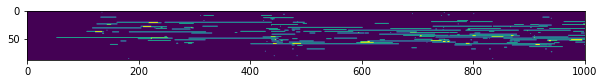

In [32]:
model = PopBaseLSTM
model_val = "BEST"
run = 1
seq,path=generate_sample(model,model_val,run,musicname="Someone_you_loved.midi",
            len_input_seq=20,ln=1000,tmp=1,model_name="PopBaseLSTM1",start_position=0)
print(path)

In [33]:
F.midiwrite(path, seq, dtm=0.1)